In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import glob
import random
import os.path as osp
from src.utils.load_cfg import ConfigLoader
from src.factories import DataAugmentationFactory, DataSamplerFactory, DatasetFactory, \
                          ModelFactory, LossFactory, InferFactory  
from src.loaders.base_loader_factory import BaseDataLoaderFactory
import pickle as pkl
from PIL import Image, ImageDraw, ImageFont
import pydicom as dcm
import numpy as np

### Split training set - validation set

In [3]:
all_scans = glob.glob("../luna16_slices/images/*")
n_scans = len(all_scans)

In [4]:
random.seed(16)
random.shuffle(all_scans)
p = int(0.7 * n_scans)
train_lst = all_scans[:p]
val_lst   = all_scans[p:]
print(len(train_lst))
print(len(val_lst))

420
180


In [5]:
train_imgs = []
for dirn in train_lst:
    train_imgs+= [osp.basename(imgpath) for imgpath in glob.glob(osp.join(dirn,"*.jpg"))]
with open("dataset_splits/luna16/train.lst","w") as fo:
    fo.write('\n'.join(train_imgs))
val_imgs = []
for dirn in val_lst:
    val_imgs+= [osp.basename(imgpath) for imgpath in glob.glob(osp.join(dirn,"*.jpg"))]
with open("dataset_splits/luna16/val.lst","w") as fo:
    fo.write('\n'.join(val_imgs))

### Visualize prediction results 

In [15]:
#Prepare dataset
data_cfg = "./configs/dataset_cfgs/luna16_slices.yaml"
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(data_cfg)
data_fact = DatasetFactory()
luna16testset = data_fact.generate(dataset_name, mode="test/test",**dataset_params)

In [16]:
preds, imgsfname = pkl.load(open("outputs/luna16_frcnn/test_predictions.pkl","rb"))
preds = preds
print("Total images     : ",len(imgsfname))
print("Total predictions: ",len(preds))

Total images     :  2196
Total predictions:  2196


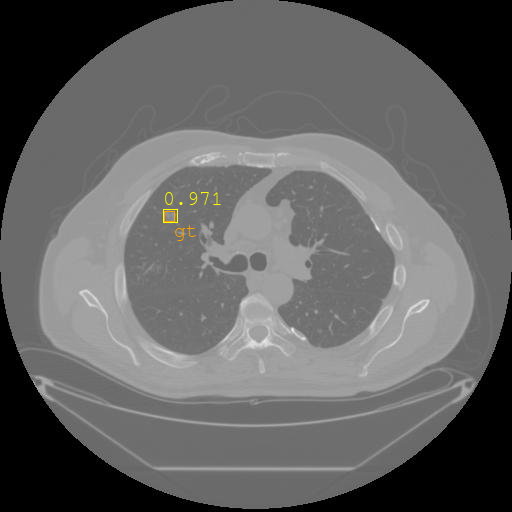

In [17]:
idx = 203
conf_thresh = 0.5
fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 20)
pil_img = Image.open(luna16testset.img_fname_lst[idx])
smpl_drw = ImageDraw.Draw(pil_img)
#Draw labels
for gt_box in (luna16testset.get_data_label(idx)[0]):
    smpl_drw.rectangle(gt_box, outline = 'orange')
    smpl_drw.text((gt_box[2],gt_box[3]), "gt", font=fnt, fill='orange')
#Draw predictions
for i,box in enumerate(preds[idx]['boxes']):
    x1,y1,x2,y2 = tuple(box.numpy())
    conf = float(preds[idx]['scores'][i])
    if (conf < conf_thresh):
        continue
    conf = "%.3f" % conf
    smpl_drw.rectangle([(x1, y1),(x2, y2)], outline = 'yellow')
    smpl_drw.text((x1,y1-20), conf, font=fnt, fill='yellow')
pil_img

In [ ]:
                
                smpl_drw.point([y,x], fill='green')
                smpl_drw.rectangle([(x-rx, y-ry),(x+rx,y+ry)], outline = 'green')

### Visualize prediction results for DICOM images (no ground truth)


In [3]:
#Prepare dataset
data_cfg = "./configs/dataset_cfgs/dcm_slices.yaml"
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(data_cfg)
data_fact = DatasetFactory()
luna16testset = data_fact.generate(dataset_name, mode="test/test",**dataset_params)


In [4]:
preds, imgsfname = pkl.load(open("outputs/dcm_frcnn/test_predictions.pkl","rb"))
preds = preds
print("Total images     : ",len(imgsfname))
print("Total predictions: ",len(preds))


Total images     :  118
Total predictions:  118


/media/nlst-data/nlst-ct/100004/T0/1.2.840.113654.2.55.195946682403058845904768502826466194287/1.2.840.113654.2.55.322164196547841664736403221907110579027


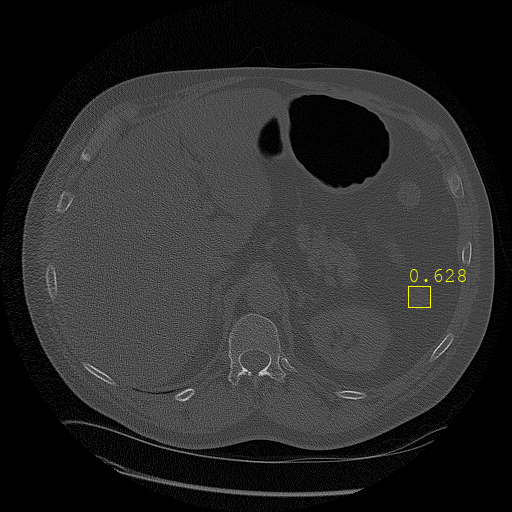

In [9]:
# Init value (change idx to get to a different image)
idx = 13
conf_thresh = 0.5
fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 20)
path = luna16testset.img_fname_lst[idx]
print(path)

# Get PIL image from DICOM
ds = dcm.dcmread(path)
# Convert to float to avoid overflow or underflow losses.
image_2d = ds.pixel_array.astype(float)
# Rescaling grey scale between 0-255
image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
# Convert to uint
image_2d_scaled = np.uint8(image_2d_scaled)
pil_img = Image.fromarray(image_2d_scaled).convert('RGB')
smpl_drw = ImageDraw.Draw(pil_img)

# #Draw labels
# for gt_box in (luna16testset.get_data_label(idx)[0]):
#     smpl_drw.rectangle(gt_box, outline = 'orange')
#     smpl_drw.text((gt_box[2],gt_box[3]), "gt", font=fnt, fill='orange')

#Draw predictions
for i,box in enumerate(preds[idx]['boxes']):
    x1,y1,x2,y2 = tuple(box.numpy())
    conf = float(preds[idx]['scores'][i])
    if (conf < conf_thresh):
        continue
    conf = "%.3f" % conf
    smpl_drw.rectangle([(x1, y1),(x2, y2)], outline = 'yellow')
    smpl_drw.text((x1,y1-20), conf, font=fnt, fill='yellow')
# Display img
pil_img
